# Inflation data

This notebook was used while exploring `Inflation-data.xlsx`

If you want to use inflation data in other notebooks, please refer to `seminartools.data.read_inflation(..)`.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Read data

In [2]:
# world bank data, ignore last 2 rows
df_hcpi = pd.read_excel(
    "./../../assets/Inflation-data.xlsx",
    sheet_name="hcpi_q",
    skipfooter=2,
).drop(
    columns = ["Indicator Type", "Series Name"]
).set_index([
    "Country Code", "IMF Country Code", "Country"
])

# identify unnamed column and remove all columns after it
unnamed_col_idx = df_hcpi.columns.str.contains("Unnamed").argmax()
df_hcpi = df_hcpi.iloc[:, :unnamed_col_idx]

# turn columns into variables, set column name to "yearmonth"
df_hcpi = df_hcpi.stack().reset_index().rename(
    columns = {
        "level_3": "yearmonth",
        0: "hcpi"
    }
)

# yearmonth is 19861, 19862. Turn into datetime (1 is Q1, 2 is Q2, 3 is Q3, 4 is Q4)

def into_datetime(yearmonth):
    yearmonth = str(yearmonth)
    year = int(yearmonth[:4])
    quarter = int(yearmonth[4])
    month = quarter * 3 - 2
    return f"{year}-{month:02d}"

df_hcpi["yearmonth"] = df_hcpi["yearmonth"].apply(into_datetime)

# if hcpi is 0, replace with NaN
df_hcpi["hcpi"] = df_hcpi["hcpi"].replace(0, np.nan)
df_hcpi = df_hcpi[df_hcpi["hcpi"].notna()]

df_hcpi

,Country Code,IMF Country Code,Country,yearmonth,hcpi
0,ABW,314,Aruba,1986-01,41.611731
1,ABW,314,Aruba,1986-04,41.705482
2,ABW,314,Aruba,1986-07,42.026911
3,ABW,314,Aruba,1986-10,42.294769
4,ABW,314,Aruba,1987-01,43.004593
...,...,...,...,...,...
30838,ZWE,698,Zimbabwe,2021-04,4984.783547
30839,ZWE,698,Zimbabwe,2021-07,5520.552280
30840,ZWE,698,Zimbabwe,2021-10,6497.511865
30841,ZWE,698,Zimbabwe,2022-01,7231.410902


In [3]:
df_hcpi.groupby("Country")["hcpi"].count().sort_values(ascending = False).head(50)

Country
Korea, Rep.              213
Norway                   213
Canada                   213
New Zealand              213
Guatemala                213
United States            213
Colombia                 213
Mauritius                213
Malaysia                 213
Cyprus                   213
Luxembourg               213
Denmark                  213
Dominican Republic       213
Japan                    213
Italy                    213
Ireland                  213
Fiji                     213
Finland                  213
France                   213
Indonesia                213
Germany                  213
Iceland                  213
Greece                   213
United Kingdom           213
Netherlands              213
Argentina                213
Singapore                213
Australia                213
Sweden                   213
Belgium                  213
Portugal                 213
South Africa             213
Philippines              213
Peru                     213
Switze

In [4]:
# We only retain the countries with 213 inflation data points
country_counts = df_hcpi.groupby("Country")["hcpi"].count()
df_hcpi = df_hcpi[df_hcpi["Country"].isin(country_counts[country_counts == country_counts.max()].index)]
df_hcpi

,Country Code,IMF Country Code,Country,yearmonth,hcpi
796,ARG,213,Argentina,1970-01,2.125775e-10
797,ARG,213,Argentina,1970-04,2.186104e-10
798,ARG,213,Argentina,1970-07,2.261299e-10
799,ARG,213,Argentina,1970-10,2.508335e-10
800,ARG,213,Argentina,1971-01,2.741703e-10
...,...,...,...,...,...
30646,ZAF,199,South Africa,2022-01,1.363000e+02
30647,ZAF,199,South Africa,2022-04,1.395000e+02
30648,ZAF,199,South Africa,2022-07,1.434000e+02
30649,ZAF,199,South Africa,2022-10,1.446160e+02


# 2. Visualize

In [5]:
df_hcpi_pct_change = df_hcpi.sort_values("yearmonth")
df_hcpi_pct_change["hcpi"] = df_hcpi_pct_change.groupby("Country")["hcpi"].pct_change()
df_hcpi_pct_change

,Country Code,IMF Country Code,Country,yearmonth,hcpi
796,ARG,213,Argentina,1970-01,NaN
14135,ITA,136,Italy,1970-01,NaN
26528,SWE,144,Sweden,1970-01,NaN
14883,JPN,158,Japan,1970-01,NaN
15886,KOR,542,"Korea, Rep.",1970-01,NaN
...,...,...,...,...,...
16098,KOR,542,"Korea, Rep.",2023-01,0.010538
15095,JPN,158,Japan,2023-01,0.004500
14347,ITA,136,Italy,2023-01,0.003938
21470,NOR,142,Norway,2023-01,0.006886


/var/folders/3m/47824pgj6rl3wf7k8lbrkm_m0000gn/T/ipykernel_25992/2194198354.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Text(0.5, 0, 'Year')

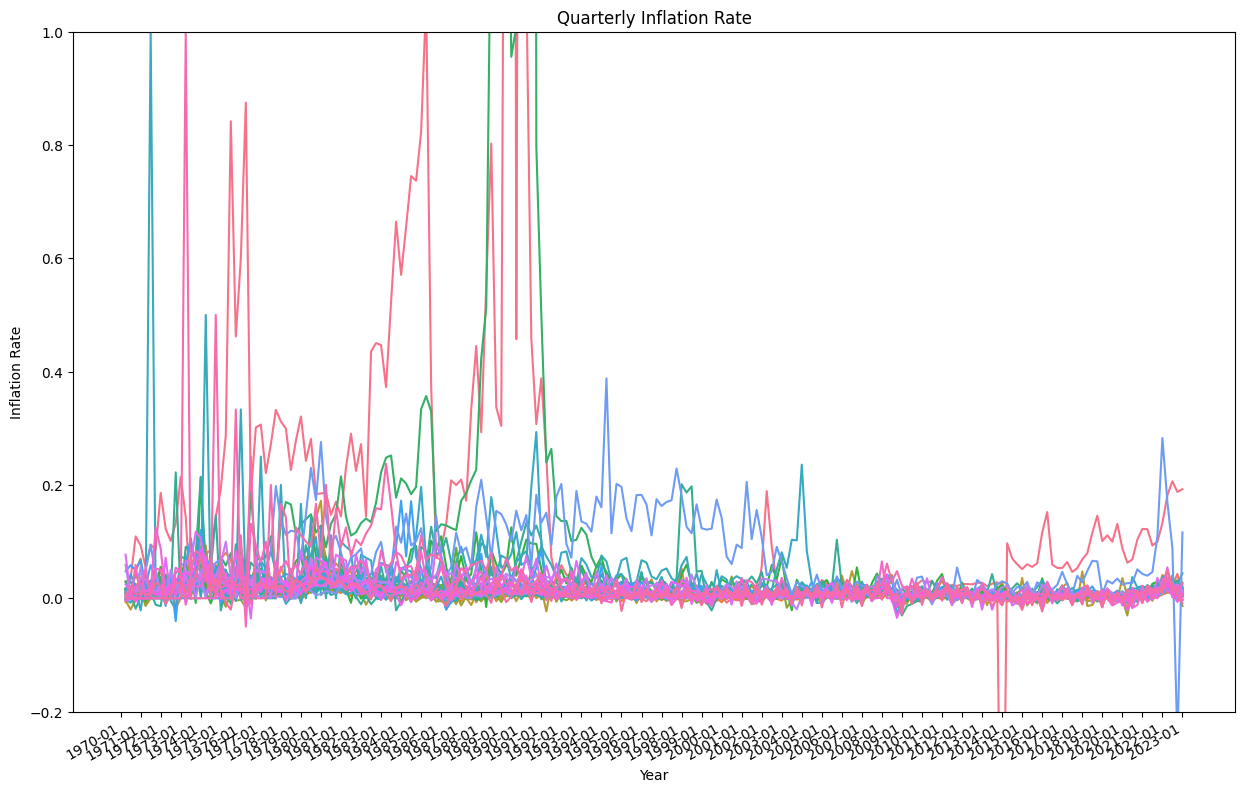

In [6]:
fig, ax = plt.subplots(figsize = (15, 10))
sns.lineplot(
    data = df_hcpi_pct_change,
    x = "yearmonth",
    y = "hcpi",
    hue = "Country",
    ax = ax
)
# remove legend
ax.legend().remove()
# only plot every 4th year
ax.set_xticks(ax.get_xticks()[::4])
fig.autofmt_xdate()
fig.show()
ax.set_ylim(-0.2, 1)
ax.set_title("Quarterly Inflation Rate")
ax.set_ylabel("Inflation Rate")
ax.set_xlabel("Year")

## Some descriptive statistics

In [7]:
df_hcpi_pivotted = df_hcpi.pivot(index='yearmonth', columns='Country Code', values='hcpi')

In [8]:
quarterly_hcpi_growth = df_hcpi_pivotted.pct_change()
annualized_hcpi_growth = (1 + quarterly_hcpi_growth) ** 4 - 1

In [9]:
# Define the rolling window size
window_size = 8

# Prepare an empty DataFrame to store the rolling correlations
correlations = pd.DataFrame(index=annualized_hcpi_growth.index[window_size-1:])  # Adjust index to match the rolling window

# Calculate rolling correlations for each pair and store in the DataFrame
for i in range(len(annualized_hcpi_growth.columns)):
    for j in range(i+1, len(annualized_hcpi_growth.columns)):
        col1 = annualized_hcpi_growth.columns[i]
        col2 = annualized_hcpi_growth.columns[j]
        
        # Column name for the correlation
        col_name = f'{col1}_vs_{col2}'
        
        # Calculate rolling correlation and add to the correlations DataFrame
        correlations[col_name] = annualized_hcpi_growth[col1].rolling(window=window_size).corr(annualized_hcpi_growth[col2])




/var/folders/3m/47824pgj6rl3wf7k8lbrkm_m0000gn/T/ipykernel_25992/498012948.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  correlations[col_name] = annualized_hcpi_growth[col1].rolling(window=window_size).corr(annualized_hcpi_growth[col2])
/var/folders/3m/47824pgj6rl3wf7k8lbrkm_m0000gn/T/ipykernel_25992/498012948.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  correlations[col_name] = annualized_hcpi_growth[col1].rolling(window=window_size).corr(annualized_hcpi_growth[col2])
/var/folders/3m/47824pgj6rl3wf7k8lbrkm_m0000

In [10]:
correlations.head()

,ARG_vs_AUS,ARG_vs_AUT,ARG_vs_BEL,ARG_vs_CAN,ARG_vs_CHE,ARG_vs_COL,ARG_vs_CYP,ARG_vs_DEU,ARG_vs_DNK,ARG_vs_DOM,...,SWE_vs_THA,SWE_vs_TUR,SWE_vs_USA,SWE_vs_ZAF,THA_vs_TUR,THA_vs_USA,THA_vs_ZAF,TUR_vs_USA,TUR_vs_ZAF,USA_vs_ZAF
yearmonth,,,,,,,,,,,,,,,,,,,,,
1971-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1972-01,0.086532,0.416948,0.344862,0.095973,0.615879,0.046911,0.276064,0.571218,-0.587709,0.102485,...,0.010130,-0.138093,-0.434093,0.570945,0.671298,-0.492476,-0.295881,-0.120291,-0.212827,-0.086471
1972-04,-0.033413,0.320735,0.106005,-0.111946,0.409764,-0.043188,-0.039720,0.528269,-0.595804,-0.056678,...,-0.235192,-0.099070,-0.419649,0.741358,0.355751,-0.338230,-0.197170,0.219056,0.021631,-0.663217
1972-07,-0.155045,0.253294,0.009325,-0.035968,0.247796,-0.125897,0.184182,0.324270,-0.416353,-0.297380,...,-0.165385,-0.126304,-0.412105,0.718941,0.221927,-0.194360,0.006559,0.371593,-0.067439,-0.540361
1972-10,-0.210921,0.323115,0.134296,-0.105284,0.345271,-0.152334,0.263125,0.353374,-0.349721,-0.159641,...,-0.385475,-0.017145,-0.524696,0.756303,-0.102116,0.277374,-0.321223,0.465234,0.012092,-0.514041


<Axes: >

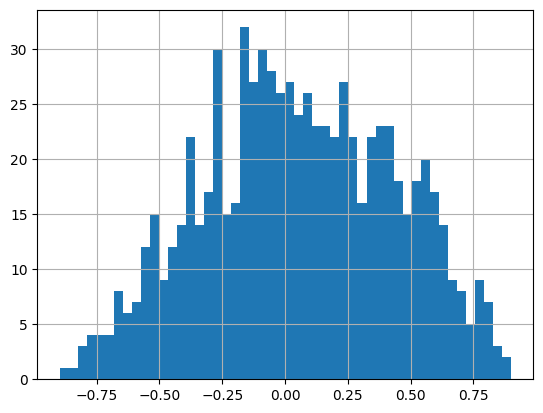

In [11]:
correlations.loc['1995-01'].hist(bins=50)

<Axes: >

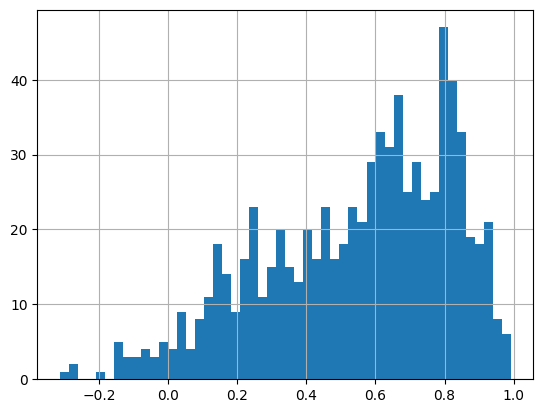

In [12]:
correlations.loc['2009-01'].hist(bins=50)

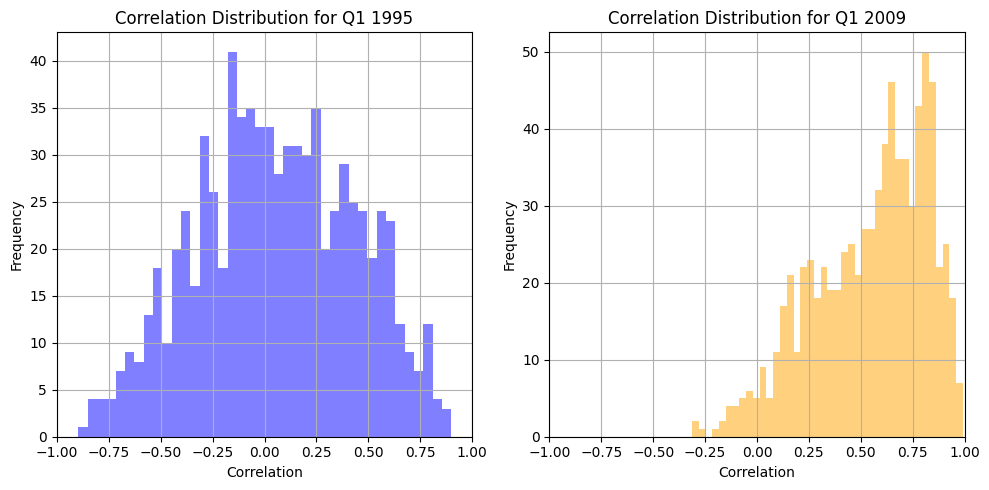

In [18]:
# We will plot two histograms next to each other, one for each period.

# Create the figure and axes
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
x_range = (-1, 1)

# Plot the histogram for the first date on the first subplot
correlations.loc['1995-01'].hist(bins=40, ax=axes[0], color='blue', alpha=0.5)
axes[0].set_title(f'Correlation Distribution for Q1 1995')
axes[0].set_xlabel('Correlation')
axes[0].set_ylabel('Frequency')
axes[0].set_xlim(x_range)

# Plot the histogram for the second date on the second subplot
correlations.loc['2009-01'].hist(bins=40, ax=axes[1], color='orange', alpha=0.5)
axes[1].set_title(f'Correlation Distribution for Q1 2009')
axes[1].set_xlabel('Correlation')
axes[1].set_ylabel('Frequency')
axes[1].set_xlim(x_range)

# Adjust the layout so there's no overlap
plt.tight_layout()
plt.show()


In [14]:
annualized_hcpi_growth['Mean'] = annualized_hcpi_growth.mean(axis=1)
annualized_hcpi_growth['Median'] = annualized_hcpi_growth.median(axis=1) * 100

In [15]:
annualized_hcpi_growth

Country Code,ARG,AUS,AUT,BEL,CAN,CHE,COL,CYP,DEU,DNK,...,PRT,PRY,SGP,SWE,THA,TUR,USA,ZAF,Mean,Median
yearmonth,,,,,,,,,,,,,,,,,,,,,
1970-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-04,0.118443,0.045707,0.036032,0.021107,0.000000,0.036415,0.000000,0.018811,0.035998,0.061997,...,0.000000,0.019577,-0.026555,0.063473,-0.018583,0.049257,0.068352,0.256882,0.054202,3.800875
1970-07,0.144850,0.045191,0.053921,0.042322,0.050945,0.048330,0.000000,0.089632,0.005883,0.124857,...,0.000000,0.009706,0.034185,0.062482,-0.003521,0.054977,0.045625,0.000000,0.041624,4.039899
1970-10,0.513946,0.090853,0.035239,0.020779,-0.024464,0.084675,0.000000,0.026959,0.038643,0.059243,...,0.256882,0.034195,0.006711,0.061521,-0.009376,0.175075,0.055736,0.000000,0.071387,5.554253
1971-01,0.427380,0.043709,0.052736,0.041661,0.025077,0.082920,0.000000,0.034175,0.099285,0.000000,...,0.000000,0.127666,0.068528,0.156584,-0.002356,0.178890,0.030651,0.241436,0.085045,6.670163
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01,0.645228,0.087942,0.083707,0.139892,0.083328,0.031807,0.160291,0.037829,0.076071,0.088965,...,0.061758,0.119170,0.068418,0.066215,0.078396,1.708487,0.094516,0.060912,0.135812,8.250297
2022-04,0.952470,0.071337,0.130508,0.069540,0.129920,0.063853,0.134355,0.213623,0.118966,0.138667,...,0.216367,0.116943,0.081670,0.137293,0.099021,0.869882,0.124363,0.097270,0.152453,11.694349
2022-07,1.118126,0.073686,0.111785,0.103813,0.033838,0.027143,0.101794,0.075340,0.066114,0.099329,...,0.043159,0.055666,0.079354,0.128990,0.040946,0.403903,0.053636,0.116606,0.107746,7.368637


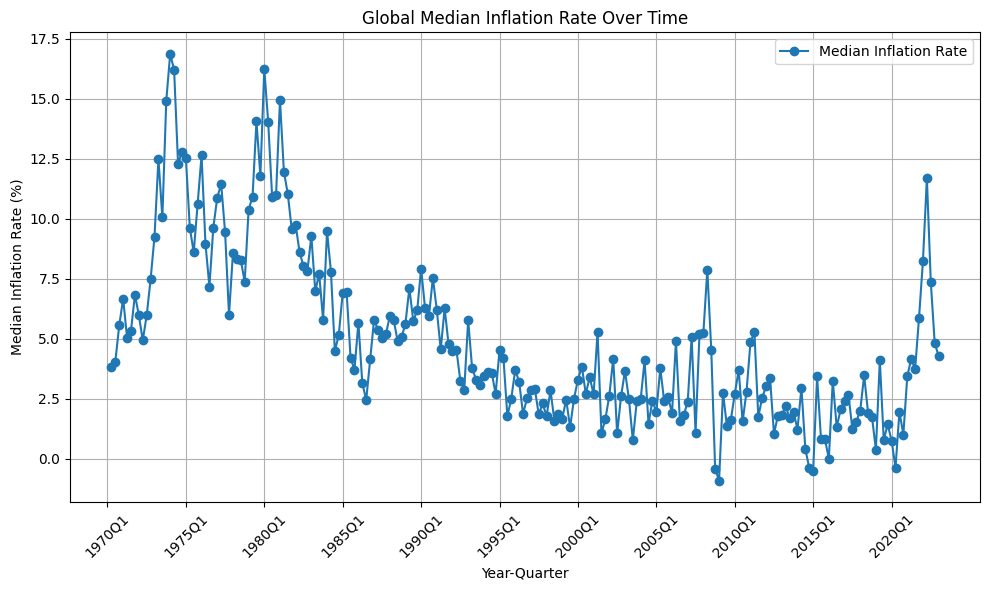

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming your DataFrame is named annualized_hcpi_growth and the index is in 'Year-Q' format as strings

# Convert the index to PeriodIndex if not already done
annualized_hcpi_growth.index = pd.PeriodIndex(annualized_hcpi_growth.index, freq='Q')

# Plotting
plt.figure(figsize=(10, 6))

# Extract and plot the 'Median' column
plt.plot(annualized_hcpi_growth.index.astype(str), annualized_hcpi_growth['Median'], marker='o', label='Median Inflation Rate')

# Generate x-ticks for every 5 years, ensuring we only label the first quarter of those years
x_ticks = [str(period) for period in annualized_hcpi_growth.index if period.year % 5 == 0 and period.quarter == 1]

# Apply custom x-ticks
plt.xticks(ticks=x_ticks, labels=x_ticks, rotation=45)

plt.title('Global Median Inflation Rate Over Time')
plt.xlabel('Year-Quarter')
plt.ylabel('Median Inflation Rate (%)')
plt.grid(True)
plt.legend()
plt.tight_layout()  # Adjusts subplot params so that the subplot(s) fits in the figure area
plt.show()
